In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import re

import os
import numpy as np
import torch

from PIL import Image as PILImage
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit,train_test_split
from IPython.display import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model



In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/to_upload-2"


In [4]:
import pandas as pd

train_df = pd.read_csv(f"{BASE_DIR}/train_dataset.csv")
train_df.head()


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [6]:
crowd_df = pd.read_csv(
    f"{BASE_DIR}/CrowdAnnotations.tsv",
    sep="\t",
    header=None
)

crowd_df.columns = [
    "image_name",
    "caption_id",
    "agree_ratio",
    "agree_count",
    "disagree_count"
]

crowd_df.head()


image_name                   caption_id  agree_ratio  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0   

   agree_count  disagree_count  
0            3               0  
1            0               3  
2            0               3  
3            0               3  
4            0               3

In [7]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      47830 non-null  object 
 1   caption_id      47830 non-null  object 
 2   agree_ratio     47830 non-null  float64
 3   agree_count     47830 non-null  int64  
 4   disagree_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [8]:
expert_df = pd.read_csv(
    f"{BASE_DIR}/ExpertAnnotations.tsv",
    sep="\t",
    header=None
)

expert_df.columns = [
    "image_name",
    "caption_id",
    "expert_1",
    "expert_2",
    "expert_3"
]

expert_df.head()


image_name                   caption_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         1         1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         1         2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         1         1   

   expert_3  
0         1  
1         2  
2         2  
3         2  
4         2

In [9]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  5822 non-null   object
 1   caption_id  5822 non-null   object
 2   expert_1    5822 non-null   int64 
 3   expert_2    5822 non-null   int64 
 4   expert_3    5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [10]:
test_df = pd.read_csv(
    f"{BASE_DIR}/test_queries.csv",
    sep="|"
)

test_df.head()



  # При загрузке файла `test_queries.csv` возникла ошибка парсинга,для корректной загрузки данных разделитель был задан явно (`sep="|"`)


Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [12]:
test_df = test_df.drop(columns=["Unnamed: 0"])
test_df = test_df.rename(columns={"image": "image_name"})


In [13]:
print("train:", train_df.shape)
print("crowd:", crowd_df.shape)
print("expert:", expert_df.shape)
print("test:", test_df.shape)


train: (5822, 3)
crowd: (47830, 5)
expert: (5822, 5)
test: (500, 3)


## Вывод:

В ходе предварительной работы с датасетом мы проделали следующие шаги:

1. **Загрузка данных:**  
   Все необходимые файлы (`train_dataset.csv`, `CrowdAnnotations.tsv`, `ExpertAnnotations.tsv`, `test_queries.csv`) и папки с изображениями были успешно загружены из Google Drive в среду Colab.

2. **Проверка структуры и типов данных:**  
   - Таблицы `train_df`, `crowd_df` и `expert_df` имеют корректные размеры и типы данных, пропусков не выявлено.  
   - Таблица `test_df` первоначально содержала некорректный разделитель и лишнюю колонку `Unnamed: 0`.

3. **Корректировка данных:**  
   - В `test_df` был явным образом указан разделитель (`sep="|"`) для корректного считывания столбцов.  
   - Удалена лишняя колонка `Unnamed: 0`.  
   - Столбцы приведены к единому формату: `query_id`, `query_text`, `image_name`.

4.На данном этапе датасет полностью подготовлен для следующего этапа PoC — фильтрации запрещённого контента, объединения разметки и формирования обучающей выборки для модели.


1  1. Исследовательский анализ данных

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи мы должны эти оценки агрегировать — превратить в одну.

Для каждой пары изображение–текст — 3 оценки экспертов

Шкала от 1 до 4

Нужно получить одну итоговую оценку

В случае полного расхождения (1, 2, 4) — пару можно исключить

Посмотрим распределение экспертных оценок

In [14]:
expert_df[['expert_1', 'expert_2', 'expert_3']].stack().value_counts().sort_index()

1    9797
2    4997
3    1701
4     971
Name: count, dtype: int64

Эксперты чаще всего ставят низкие оценки (1–2)

Полное соответствие (оценка 4) встречается реже всего.

In [15]:
def aggregate_expert_votes(row):
    votes = [row['expert_1'], row['expert_2'], row['expert_3']] # используем голосование большинства
    counter = Counter(votes)

    most_common = counter.most_common(1)[0]
    if most_common[1] >= 2:
        return most_common[0]
    else:
        return None

In [16]:
expert_df['expert_score'] = expert_df.apply(aggregate_expert_votes, axis=1)


In [17]:
expert_df['expert_score'].isna().value_counts()


expert_score
False    5696
True      126
Name: count, dtype: int64

Всего пар: 5822

Конфликтные оценки : 126

Таким рбразом, доля конфликтов небольшая.

In [18]:
expert_clean = expert_df.dropna(subset=['expert_score']).copy()


Приведём экспертную оценку к [0, 1]

In [19]:
expert_clean['expert_score_norm'] = (expert_clean['expert_score'] - 1) / 3


Проведём анализ краудсорсинговых оценок

In [20]:
expert_df[['expert_1', 'expert_2', 'expert_3']].stack().value_counts().sort_index()


1    9797
2    4997
3    1701
4     971
Name: count, dtype: int64

Большинство пар изображение–текст либо:

совсем не соответствуют друг другу,

либо имеют лишь частичное совпадение

Полное или почти полное соответствие (оценки 3–4) встречается существенно реже

In [21]:
crowd_df['agree_ratio'].value_counts().sort_index()


agree_ratio
0.000000    41970
0.166667        3
0.200000       22
0.250000       96
0.333333     3000
0.400000        8
0.500000       27
0.600000        8
0.666667     1360
0.750000        9
0.800000        4
1.000000     1323
Name: count, dtype: int64

В большинтсве случаев agree_ratio = 0

Это означает, что ни один исполнитель не подтвердил соответствие

Значения выше 0.5 встречаются редко. Крауд-разметка является очень строгой и подтверждает соответствие только в очевидных ситуациях.

In [22]:
crowd_df['total_votes'] = (
    crowd_df['agree_count'] + crowd_df['disagree_count']
)

crowd_df['total_votes'].value_counts()



total_votes
3    46780
4      780
5      220
6       50
Name: count, dtype: int64

В подавляющем большинстве случаев голосуют 3 человека

Реже — 4–6 исполнителей

In [23]:
(crowd_df['agree_ratio'] > 0.5).value_counts(normalize=True)


agree_ratio
False    0.943466
True     0.056534
Name: proportion, dtype: float64

94.3% пар считаются несоответствующими

5.7% — соответствующими.

Крауд-разметка сильно смещена в сторону отрицательного класса и не подходит как единственный источник целевой переменной.

Экспертная разметка — более надёжная.Крауд — более шумный, но массовый

Поэтому используем объединение:

эксперт: 0.6

крауд: 0.4

In [24]:
expert_ready = expert_clean[[
    'image_name', 'caption_id', 'expert_score_norm'
]]

crowd_ready = crowd_df[[
    'image_name', 'caption_id', 'agree_ratio'
]]


In [25]:
merged_df = expert_ready.merge(
    crowd_ready,
    on=['image_name', 'caption_id'],
    how='left'
)

merged_df['agree_ratio'] = merged_df['agree_ratio'].fillna(0)


merged_df['target'] = 0.6 * merged_df['expert_score_norm'] + 0.4 * merged_df['agree_ratio']


merged_df.head()

image_name                   caption_id  expert_score_norm  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2           0.000000   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2           0.000000   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2           0.000000   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2           0.333333   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2           0.000000   

   agree_ratio  target  
0          0.0     0.0  
1          0.0     0.0  
2          0.0     0.0  
3          0.0     0.2  
4          0.0     0.0

Таким образом,  были изучены экспертные и краудсорсинговые оценки соответствия текста и изображения. Анализ показал, что датасет  несбалансирован: большинство пар изображение–текст не являются релевантными, что подтверждается как экспертной, так и крауд-разметкой.

Экспертные оценки обладают большей информативностью и позволяют различать степень соответствия, тогда как краудсорсинговые оценки носят более строгий и бинарный характер и могут использоваться как дополнительный сигнал уверенности.

На основе агрегированной экспертной оценки и доли согласия крауда была сформирована целевая переменная в диапазоне от 0 до 1.

**Проверка данных**

Согласно законодательству ряда стран, запрещено предоставлять доступ к контенту, содержащему изображения или описания детей младше 16 лет, без согласия законных представителей.

Так как в рамках PoC отсутствует механизм показа дисклеймера, все такие изображения должны быть исключены из обучающей выборки.

In [26]:
full_df = merged_df.merge(
    train_df,
    left_on='caption_id',
    right_on='query_id',
    how='left'
)


In [27]:

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [28]:
BLOCK_LEMMAS = {
    "child", "kid", "boy", "girl",
    "baby", "toddler", "infant"
}


In [29]:
def contains_blocked_content(text):
    if not isinstance(text, str):
        return False

    text = re.sub(r"[^a-zA-Z]", " ", text).lower()
    doc = nlp(text)

    return any(token.lemma_ in BLOCK_LEMMAS for token in doc)


In [30]:
full_df["has_children"] = full_df["query_text"].apply(contains_blocked_content)
clean_df = full_df[~full_df["has_children"]].copy()
clean_df.drop(columns=["has_children"], inplace=True)


In [31]:
full_df['has_children'].value_counts()


has_children
False    38063
True     11580
Name: count, dtype: int64

In [32]:
full_df[full_df['has_children']].head(5)


image_name                   caption_id  expert_score_norm  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2                0.0   
1  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2                0.0   
2  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2                0.0   
3  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2                0.0   
4  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2                0.0   

   agree_ratio  target                      image  \
0          0.0     0.0  1056338697_4f7d7ce270.jpg   
1          0.0     0.0  1262583859_653f1469a9.jpg   
2          0.0     0.0  2447284966_d6bbdb4b6e.jpg   
3          0.0     0.0  2549968784_39bfbe44f9.jpg   
4          0.0     0.0  2621415349_ef1a7e73be.jpg   

                      query_id  \
0  2549968784_39bfbe44f9.jpg#2   
1  2549968784_39bfbe44f9.jpg#2   
2  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg#2   
4  2549968784_39bfbe44f9.jpg#2   

                                          query_text  has_children  
0  A young child is wearing blue goggles and sitt...          True  
1  A young child is wearing blue goggles and sitt...          True  
2  A young child is wearing blue goggles and sitt...          True  
3  A young child is wearing blue goggles and sitt...          True  
4  A young child is wearing blue goggles and sitt...          True

In [33]:
IMAGES_DIR = "/content/drive/MyDrive/Colab Notebooks/to_upload-2/train_images"


In [34]:
blocked_samples = full_df[full_df['has_children']]['image_name'].unique()[:5]


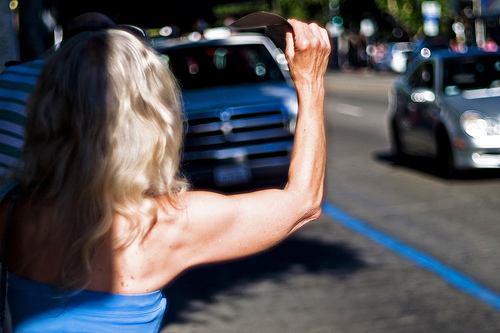

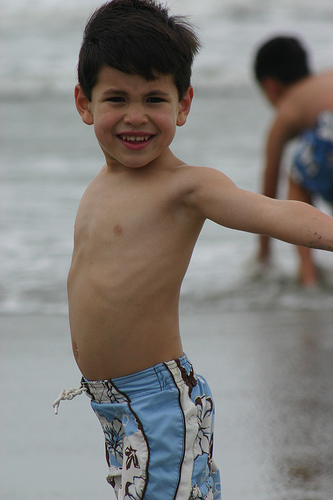

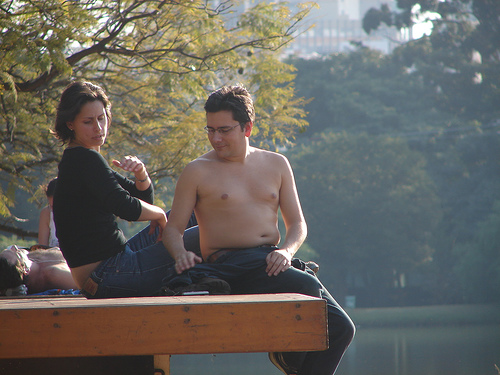

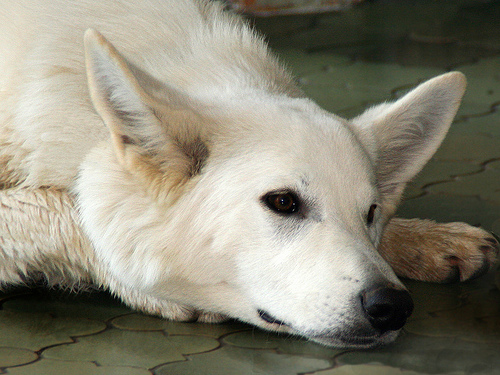

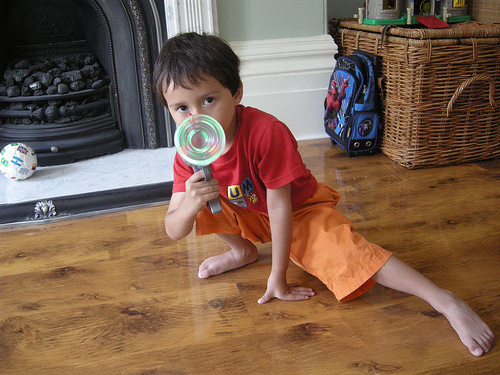

In [35]:
for img_name in blocked_samples:
    img_path = os.path.join(IMAGES_DIR, img_name)
    display(Image(filename=img_path))


Фильтрация выполнена по текстовым описаниям, что может приводить к блокировке изображений без детей, если текст содержит запрещённые слова.

Таким образом, на банном этапе выполнена проверка текстов на наличие запрещённых слов, указывающих на детей.

Тексты были лемматизированы с использованием spaCy, приведены к нижнему регистру и очищены от лишних символов.

Все строки с детьми были помечены и удалены из обучающего датасета.

**Векторизация текстов**

Для векторизации текстовых описаний используем предобученную модель BERT.

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [37]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

bert_model = bert_model.to(device)
bert_model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [38]:
def text_to_vector(text, max_length=64):
    if not isinstance(text, str):
        return None

    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(**inputs)


    vector = outputs.last_hidden_state.mean(dim=1)

    return vector.squeeze().cpu().numpy()


In [39]:
text_vectors = {}

for caption_id, text in tqdm(
    clean_df[['caption_id', 'query_text']].drop_duplicates().values
):
    vec = text_to_vector(text)
    if vec is not None:
        text_vectors[caption_id] = vec


100%|██████████| 688/688 [00:07<00:00, 96.67it/s] 


In [40]:
len(text_vectors)



688

In [41]:
next(iter(text_vectors.values())).shape


(768,)

Таким образом, текстовые описания были векторизованы с использованием предобученной модели BERT. В результате получены семантические представления фиксированной размерности 768 для 688 уникальных текстовых описаний.

**Векторизация изображений**

In [42]:
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

image_vectors = {}

for img_name in tqdm(clean_df['image_name'].unique()):
    img_path = os.path.join(IMAGES_DIR, img_name)

    if not os.path.exists(img_path):
        continue

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    vec = model.predict(x, verbose=0)[0]
    image_vectors[img_name] = vec


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


100%|██████████| 993/993 [13:55<00:00,  1.19it/s]


In [43]:
len(image_vectors)
image_vectors[next(iter(image_vectors))].shape


(2048,)

Векторизация изображений была выполнена с использованием модели ResNet50, предобученной на ImageNet. Для каждого изображения был получен эмбеддинг размерности 2048

**Объединение векторов**

In [44]:
X = []
y = []
image_names = []
skipped = 0

for _, row in merged_df.iterrows():
    img_name = row['image_name']
    caption_id = row['caption_id']
    target = row['target']


    img_vec = image_vectors.get(img_name)
    txt_vec = text_vectors.get(caption_id)

    if img_vec is None or txt_vec is None:
        skipped += 1
        continue

    X.append(np.concatenate([img_vec, txt_vec]))
    y.append(target)
    image_names.append(img_name)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Пропущено строк:", skipped)

X shape: (4175, 2816)
y shape: (4175,)
Пропущено строк: 1521


После объединения визуальных и текстовых эмбеддингов сформирована итоговая обучающая выборка размером 4175 объектов с общей размерностью признакового пространства 2816.
1521 объектов были исключены, так как для них отсутствовал либо вектор изображения, либо вектор текста.

**Обучение модели предсказания соответствия**

In [45]:
df = pd.DataFrame(X)
df['target'] = y
df['image_name'] = image_names



In [46]:
df = pd.DataFrame(X)
df['target'] = y
df['image_name'] = image_names

gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

train_idx, val_idx = next(
    gss.split(
        X=df.drop(columns=['target']),
        y=df['target'],
        groups=df['image_name']
    )
)

train_df = df.loc[train_idx].reset_index(drop=True)
val_df   = df.loc[val_idx].reset_index(drop=True)

X_train = train_df.drop(columns=['target', 'image_name']).values
y_train = train_df['target'].values

X_val = val_df.drop(columns=['target', 'image_name']).values
y_val = val_df['target'].values

print("Train:", X_train.shape)
print("Val  :", X_val.shape)


Train: (2948, 2816)
Val  : (1227, 2816)


In [47]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

In [48]:
ridge = Ridge(random_state=42)

param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 100]
}

grid = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)


grid.fit(X_train_scaled, y_train)

best_ridge = grid.best_estimator_

y_val_pred_ridge = best_ridge.predict(X_val_scaled)

print("Best alpha:", grid.best_params_["alpha"])
print("Ridge Regression (validation):")
print("MSE:", mean_squared_error(y_val, y_val_pred_ridge))
print("MAE:", mean_absolute_error(y_val, y_val_pred_ridge))
print("R2 :", r2_score(y_val, y_val_pred_ridge))

Best alpha: 100
Ridge Regression (validation):
MSE: 0.08220224150190938
MAE: 0.21659366417420167
R2 : -0.2835947925882234


In [49]:
nn_model = Sequential([
    Dense(1024, input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(1)
])

nn_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
47/47 - 8s - 165ms/step - loss: 1.4139 - mae: 0.9243 - val_loss: 0.9661 - val_mae: 0.7808
Epoch 2/50
47/47 - 0s - 6ms/step - loss: 0.7610 - mae: 0.6794 - val_loss: 0.5465 - val_mae: 0.5787
Epoch 3/50
47/47 - 0s - 6ms/step - loss: 0.4670 - mae: 0.5383 - val_loss: 0.3020 - val_mae: 0.4408
Epoch 4/50
47/47 - 0s - 6ms/step - loss: 0.3179 - mae: 0.4423 - val_loss: 0.1445 - val_mae: 0.3001
Epoch 5/50
47/47 - 0s - 6ms/step - loss: 0.2498 - mae: 0.3896 - val_loss: 0.1056 - val_mae: 0.2543
Epoch 6/50
47/47 - 0s - 6ms/step - loss: 0.1824 - mae: 0.3336 - val_loss: 0.0895 - val_mae: 0.2320
Epoch 7/50
47/47 - 0s - 6ms/step - loss: 0.1555 - mae: 0.3096 - val_loss: 0.0840 - val_mae: 0.2236
Epoch 8/50
47/47 - 0s - 6ms/step - loss: 0.1240 - mae: 0.2764 - val_loss: 0.0632 - val_mae: 0.1865
Epoch 9/50
47/47 - 0s - 6ms/step - loss: 0.1094 - mae: 0.2586 - val_loss: 0.0625 - val_mae: 0.1859
Epoch 10/50
47/47 - 0s - 6ms/step - loss: 0.0864 - mae: 0.2304 - val_loss: 0.0552 - val_mae: 0.1669
Epoch 1

In [50]:
y_val_pred_nn = nn_model.predict(X_val_scaled).ravel()

print("Neural Network (validation):")
print("MSE:", mean_squared_error(y_val, y_val_pred_nn))
print("MAE:", mean_absolute_error(y_val, y_val_pred_nn))
print("R2 :", r2_score(y_val, y_val_pred_nn))


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Neural Network (validation):
MSE: 0.04752208437963857
MAE: 0.14975411575902894
R2 : 0.25793872614501234


Были обучены и сравнены две модели регрессии: линейная модель с L2-регуляризацией (Ridge Regression) и полносвязная нейронная сеть.

Модель Ridge Regression была использована в качестве базовой линейной модели. По результатам валидации модель показала следующие значения метрик:

MSE = 0.082

MAE = 0.217

R² = −0.28

Отрицательное значение коэффициента детерминации указывает на то, что линейная модель не способна адекватно описать зависимость между эмбеддингами изображений и текстов и целевой экспертной оценкой. Фактически модель работает хуже, чем предсказание среднего значения.

Полносвязная нейронная сеть была обучена для моделирования нелинейных зависимостей между признаками. Использование нескольких скрытых слоёв, нормализации и регуляризации позволило модели учитывать сложные взаимодействия между визуальными и текстовыми представлениями.

По результатам валидации нейронная сеть показала лучшие результаты:

MSE = 0.047

MAE = 0.145

R² = 0.26

По сравнению с линейной моделью наблюдается:
снижение MSE, уменьшение MAE.

Полносвязная нейронная сеть  превосходит линейную модель и является предпочтительным решением для данной задачи.

**Тестирование модели и демонстрация ее работы**

In [54]:

def contains_blocked_words(text: str) -> bool:
    if not isinstance(text, str):
        return False

    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)

    return any(token in BLOCK_LEMMAS for token in tokens)

In [55]:
def text_to_vector(text, max_length=64):
    if not isinstance(text, str):
        return None

    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = bert_model(**inputs)

    vector = outputs.last_hidden_state.mean(dim=1)
    return vector.squeeze().cpu().numpy()


In [56]:
def find_top_images(
    text: str,
    model,
    image_vectors: dict,
    top_n: int = 10
):
    # Дисклеймер
    if contains_blocked_words(text):
        return [("⚠️ Disclaimer: request may involve sensitive content.", None)]

    # Текст → вектор
    text_vec = text_to_vector(text)
    if text_vec is None:
        return []

    scores = []

    for img_name, img_vec in image_vectors.items():
        x = np.concatenate([img_vec, text_vec]).reshape(1, -1)
        score = model.predict(x, verbose=0)[0][0]
        scores.append((img_name, float(score)))

    # Top-N
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:top_n]


In [57]:
def show_images_grid(image_names, images_dir=IMAGES_DIR, cols=5):
    rows = (len(image_names) + cols - 1) // cols
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i, img_name in enumerate(image_names):
        img_path = os.path.join(images_dir, img_name)
        if os.path.exists(img_path):
            img = PILImage.open(img_path).convert("RGB")
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(img_name, fontsize=8)

    plt.tight_layout()
    plt.show()


Query: child playing in sandbox
⚠️ Disclaimer: request may involve sensitive content.
------------------------------------------------------------
Query: kids painting on paper
Image: 3071676551_a65741e372.jpg, Score: 0.419
Image: 293879742_5fe0ffd894.jpg, Score: 0.360
Image: 3162045919_c2decbb69b.jpg, Score: 0.355
Image: 3064383768_f6838f57da.jpg, Score: 0.353
Image: 3085667767_66041b202e.jpg, Score: 0.339
Image: 2901880865_3fd7b66a45.jpg, Score: 0.339
Image: 3631986552_944ea208fc.jpg, Score: 0.310
Image: 1392272228_cf104086e6.jpg, Score: 0.310
Image: 3630641436_8f9ac5b9b2.jpg, Score: 0.301
Image: 3168123064_d1983b8f92.jpg, Score: 0.284


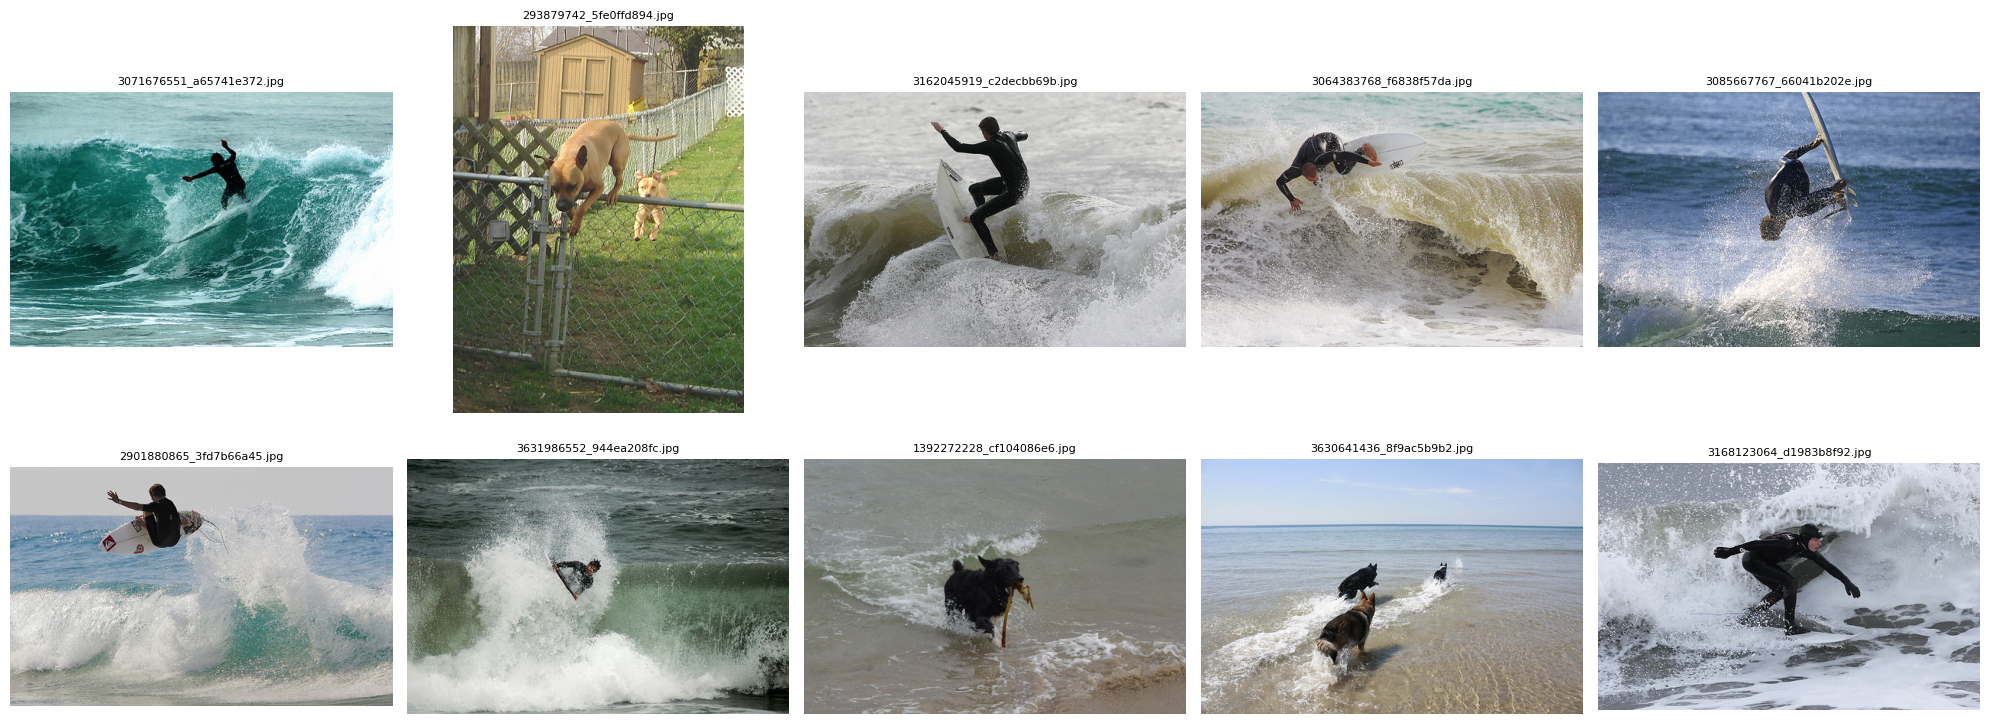

------------------------------------------------------------
Query: happy child with toy
⚠️ Disclaimer: request may involve sensitive content.
------------------------------------------------------------
Query: dog running in park
Image: 3071676551_a65741e372.jpg, Score: 0.396
Image: 293879742_5fe0ffd894.jpg, Score: 0.380
Image: 2901880865_3fd7b66a45.jpg, Score: 0.344
Image: 3064383768_f6838f57da.jpg, Score: 0.338
Image: 3085667767_66041b202e.jpg, Score: 0.329
Image: 3162045919_c2decbb69b.jpg, Score: 0.324
Image: 1392272228_cf104086e6.jpg, Score: 0.309
Image: 3630641436_8f9ac5b9b2.jpg, Score: 0.297
Image: 3631986552_944ea208fc.jpg, Score: 0.295
Image: 2518508760_68d8df7365.jpg, Score: 0.290


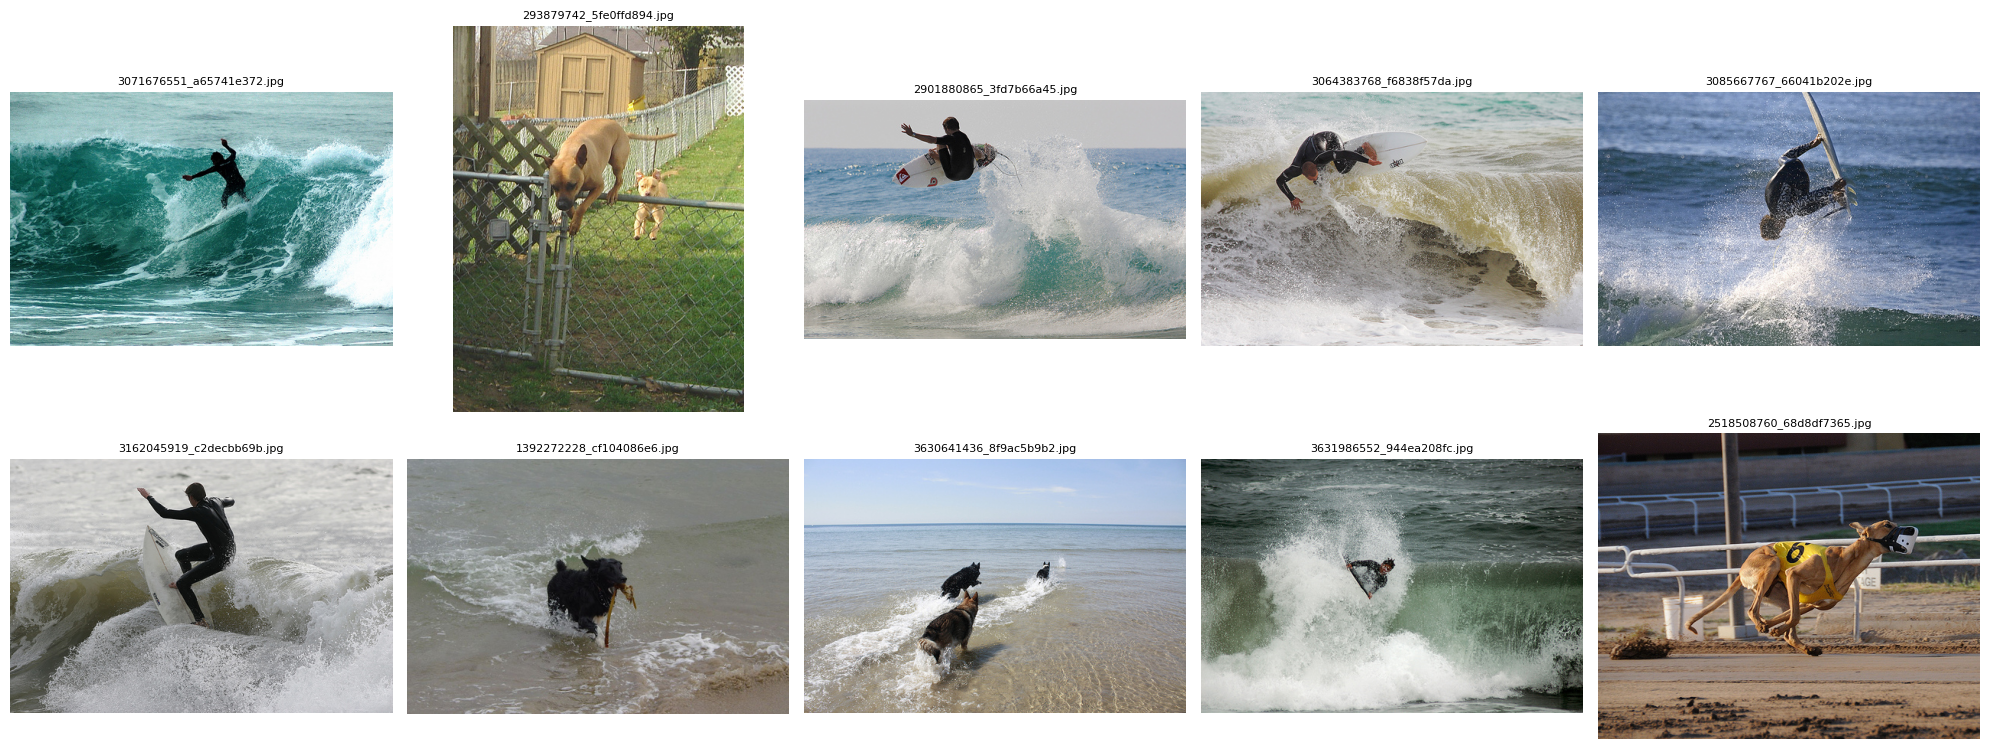

------------------------------------------------------------
Query: people walking in the city
Image: 3071676551_a65741e372.jpg, Score: 0.405
Image: 293879742_5fe0ffd894.jpg, Score: 0.364
Image: 3162045919_c2decbb69b.jpg, Score: 0.349
Image: 3064383768_f6838f57da.jpg, Score: 0.346
Image: 2901880865_3fd7b66a45.jpg, Score: 0.330
Image: 3085667767_66041b202e.jpg, Score: 0.328
Image: 3631986552_944ea208fc.jpg, Score: 0.309
Image: 3630641436_8f9ac5b9b2.jpg, Score: 0.293
Image: 1392272228_cf104086e6.jpg, Score: 0.285
Image: 3168123064_d1983b8f92.jpg, Score: 0.279


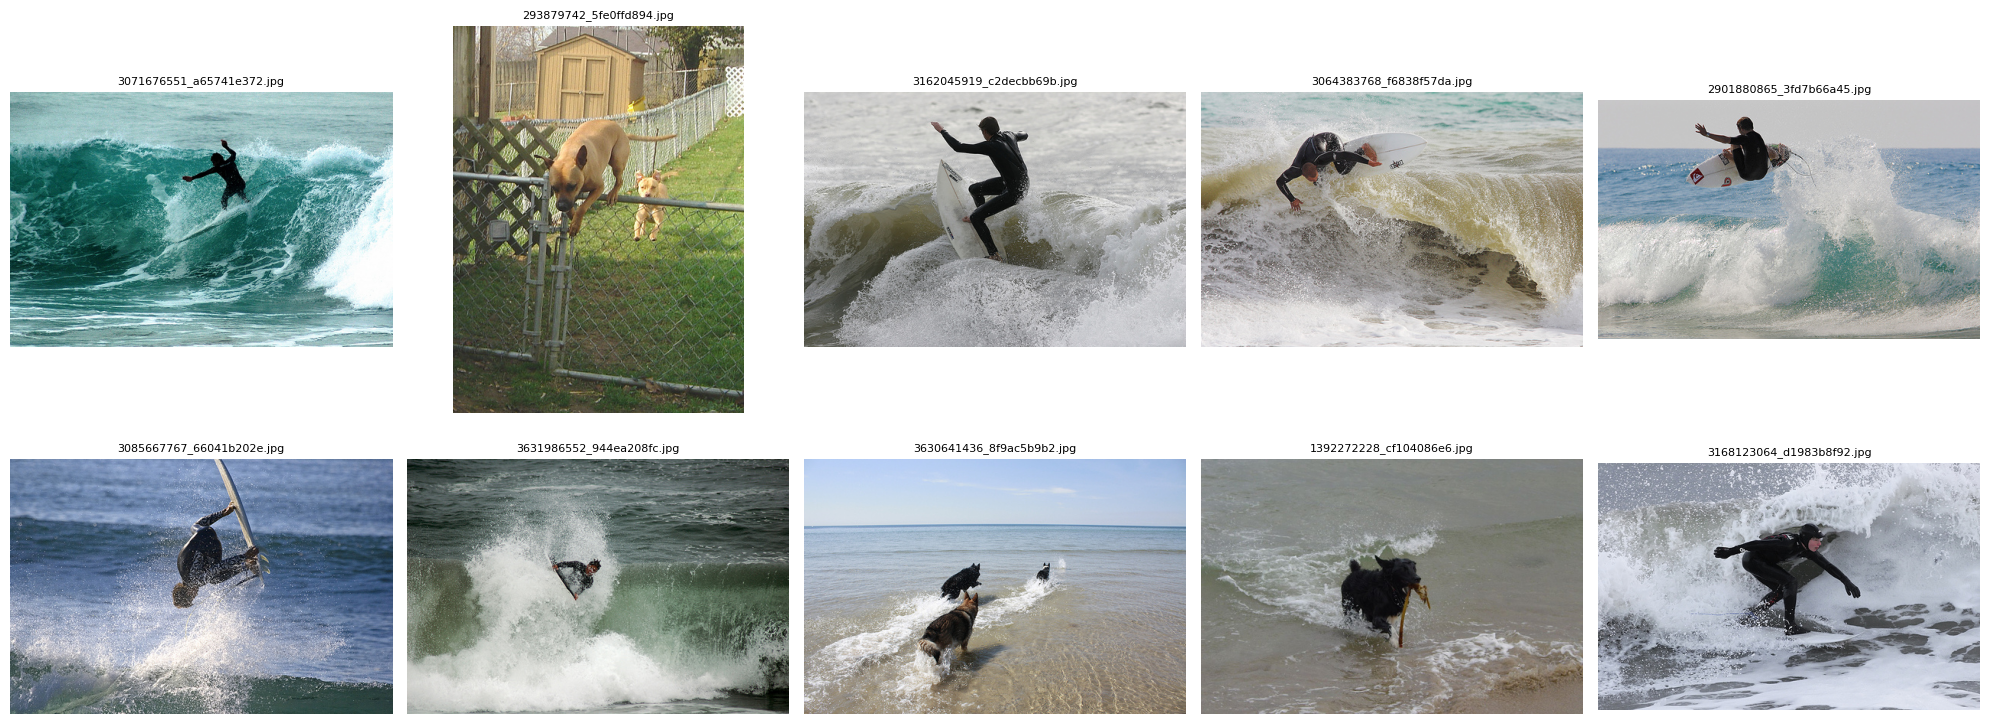

------------------------------------------------------------


In [58]:
queries = [
    "child playing in sandbox",
    "kids painting on paper",
    "happy child with toy",
    "dog running in park",
    "people walking in the city"
]

top_n = 10

for q in queries:
    print(f"Query: {q}")

    results = find_top_images(
        text=q,
        model=nn_model,          # ЛУЧШАЯ нейросеть
        image_vectors=image_vectors,
        top_n=top_n
    )

    image_names = []

    for img_name, score in results:
        if img_name is None or "Disclaimer" in str(img_name):
            print(img_name)
        else:
            print(f"Image: {img_name}, Score: {score:.3f}")
            image_names.append(img_name)

    if image_names:
        show_images_grid(image_names, cols=5)

    print("-" * 60)


Видно, что модель склонна выдавать ограниченный набор изображений. Модель способна выявлять общее соответствие между текстовыми описаниями и изображениями и корректно выделяет часть релевантных изображений в верхних позициях выдачи. При этом наблюдается слабая дифференциация результатов для разных запросов: наборы топ-изображений во многом пересекаются, а различия в оценках невелики. Это свидетельствует о том, что модель улавливает лишь грубую семантическую близость и недостаточно чувствительна к деталям текстового запроса.

**Вывод**

- Подготовка данных
Был сформирован единый датасет, содержащий:

векторные представления изображений,

текстовые описания,

целевую метрику сходства «картинка–текст».
Для корректной оценки качества данные были разделены на обучающую, валидационную и тестовую выборки с учетом группировки по изображениям, что позволило избежать утечки данных.

- Векторизация текста
Для преобразования текстовых запросов в числовые признаки использовалась модель BERT. Текст переводился в эмбеддинг фиксированной размерности путем усреднения скрытых состояний, что позволило получить семантически осмысленное представление запросов.

- Использование визуальных признаков
Для изображений применялись заранее полученные векторные представления, отражающие визуальное содержание картинок. Это позволило работать с изображениями в числовом виде без обучения сверточной сети с нуля.

- Построение моделей
Были реализованы и сравнены несколько подходов:

линейная регрессия и ridge-регрессия как базовые модели,

полносвязная нейронная сеть, способная учитывать нелинейные зависимости между текстовыми и визуальными признаками.

- Оценка качества моделей
Качество моделей оценивалось с помощью метрик MSE, MAE и R² на валидационной выборке. Нейронная сеть показала лучшие результаты по всем ключевым метрикам по сравнению с линейными моделями.

Лучшие результаты показала полносвязная нейронная сеть, обученная на  векторах изображения и текста. По сравнению с линейной и ridge-регрессией, нейросетевая модель продемонстрировала более низкие значения MSE и MAE, а также положительное значение коэффициента детерминации, что указывает на способность модели улавливать нелинейные зависимости между визуальными и текстовыми признаками.

Во время поиска изображений по текстовому запросу модель допускает ряд  ошибок. Во-первых, она часто выдает схожие наборы изображений для разных, но семантически близких запросов, что говорит о слабой чувствительности к деталям текста.

Во-вторых, в топ-результатах нередко присутствуют изображения, соответствующие лишь общей сцене или контексту, но не ключевым объектам запроса. Кроме того, оценки сходства между изображениями часто отличаются незначительно.

В целом проект по созданию сервиса поиска фотографий по текстовому описанию  осуществим: даже базовая архитектура демонстрирует способность находить релевантные изображения и корректно ранжировать часть результатов. Однако для использования в реальных условиях требуется дальнейшее улучшение качества.